# Movie recommendation using MovieLens data

Importing required packages

In [4]:
import pandas as pd
import graphlab
from sklearn.model_selection import train_test_split,KFold
from matplotlib import pyplot as plt
import numpy as np
import nltk

## Data exploration

Importing datasets from csv file

In [6]:
links = pd.read_csv("links.csv")
movies = pd.read_csv("movies.csv")
ratings = pd.read_csv("ratings.csv")
tags = pd.read_csv("tags.csv")

## Exploring Links dataset

In [3]:
#checking the head of the links dataset (at movie ID level)
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [4]:
#checking the shape of the links dataset
links_shape = links.shape
print("Shape of links dataset = {}".format(links_shape))

Shape of links dataset = (9125, 3)


In [5]:
#number of unique movie Ids in the links dataset
uni_movieIds_links = links["movieId"].nunique()
print("No of unique movieIds in links dataset = {}".format(uni_movieIds_links))

No of unique movieIds in links dataset = 9125


In [6]:
#checking if a column has null values 
links.isnull().any()

movieId    False
imdbId     False
tmdbId      True
dtype: bool

In [7]:
#looking at rows with missing tmdbid
links[links["tmdbId"].isnull()].head()

,movieId,imdbId,tmdbId
607,720,118114,NaN
608,721,114103,NaN
640,769,116992,NaN
910,1133,111357,NaN
2282,2851,81454,NaN


In [8]:
#number of movies from which tmdbid is missing (13)
missing_tmdbId = links.loc[links["tmdbId"].isnull(), "movieId"].nunique()
print("{} movies have missing tmdbId".format(missing_tmdbId))

13 movies have missing tmdbId


In [9]:
#Replacing the missing TmdbId with Zero
links.loc[(links.tmdbId.isnull()) , "tmdbId"] = 0

From the analysis above we can see that the links dataset contains three columns: movieId, tmdbId and imdbId for 9125 movies. Of the three columns tmdbId has missing values. The 13 movies for which tmdbId is missing, we replaced with it with zero for our analysis.  

## Exploring Movies Dataset

In [10]:
#checking the head of the movies dataset (at movie ID level)
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [11]:
#checking the shape of the movies dataset
movies_shape = movies.shape
print("Shape of movies dataset = {}".format(movies_shape))

Shape of movies dataset = (9125, 3)


In [12]:
#Data is unique at movie Id level
no_movies = movies["movieId"].nunique()
print("No of unique movies in movies dataset = {}".format(no_movies))

No of unique movies in movies dataset = 9125


In [13]:
#checking for mising values 
movies.isnull().any()

movieId    False
title      False
genres     False
dtype: bool

In [14]:
#checking if the genres have not been listed
no_genre = movies.loc[movies.genres == "(no genres listed)"].movieId.count()
print("{} movies dont have genres listed".format(no_genre) )

18 movies dont have genres listed


In [15]:
#creating a new dataset with genres split into different columns
movies2 = pd.DataFrame(movies.genres.str.split('|').tolist(), columns = ["genres1","genres2","genres3","genres4","genres5","genres6","genres7","genres8","genres9","genres10"])

In [16]:
#concatenating the two datasets to create the final movies dataset
movies_new = pd.concat([movies,movies2],axis = 1)
movies_new.head()

,movieId,title,genres,genres1,genres2,genres3,genres4,genres5,genres6,genres7,genres8,genres9,genres10
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure,Animation,Children,Comedy,Fantasy,None,None,None,None,None
1,2,Jumanji (1995),Adventure|Children|Fantasy,Adventure,Children,Fantasy,None,None,None,None,None,None,None
2,3,Grumpier Old Men (1995),Comedy|Romance,Comedy,Romance,None,None,None,None,None,None,None,None
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Comedy,Drama,Romance,None,None,None,None,None,None,None
4,5,Father of the Bride Part II (1995),Comedy,Comedy,None,None,None,None,None,None,None,None,None


In [17]:
#creating the year of release dataset from the title column
movies_new["Year_release"] = movies_new['title'].str.extract('(\d\d\d\d)', expand=True)
movies_new.head()

,movieId,title,genres,genres1,genres2,genres3,genres4,genres5,genres6,genres7,genres8,genres9,genres10,Year_release
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure,Animation,Children,Comedy,Fantasy,None,None,None,None,None,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,Adventure,Children,Fantasy,None,None,None,None,None,None,None,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,Comedy,Romance,None,None,None,None,None,None,None,None,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Comedy,Drama,Romance,None,None,None,None,None,None,None,1995
4,5,Father of the Bride Part II (1995),Comedy,Comedy,None,None,None,None,None,None,None,None,None,1995


In [18]:
movies_new.isnull().any()

movieId         False
title           False
genres          False
genres1         False
genres2          True
genres3          True
genres4          True
genres5          True
genres6          True
genres7          True
genres8          True
genres9          True
genres10         True
Year_release     True
dtype: bool

In [19]:
#No of movies with missing year of release 
missing_year = movies_new.loc[movies_new['Year_release'].isnull(),'movieId'].nunique()
print("{} movies have missing year of release".format(missing_year))

4 movies have missing year of release


In [20]:
#Adding the missing Year_release for 4 movies manually
movies_new.loc[9017,"Year_release"] = "2015"
movies_new.loc[9063,"Year_release"] = "2016"
movies_new.loc[9118,"Year_release"] = "2016"
movies_new.loc[9124,"Year_release"] = "2014"

We can see that movies dataset contains three columns: movieId, title and genre for 9125 unique movies. The genre is missing for 18 movies which is listed as "(no genre listed)". The genre is split into different columns and saved for analyses.
The year of release is missing for 4 movies which we inserted in the dataset. 

## Merging movies and links data - Movie Level Information

In [21]:
#merging the the links and movies datasets as both are on movie ID level
movies_links = pd.merge(movies_new,links, on = "movieId")
movies_links.head()
movies_links.shape
movies_links_shape = movies_links.shape
print("Shape of movies_links dataset = {}".format(movies_links_shape))

Shape of movies_links dataset = (9125, 16)


In [22]:
movies_links.isnull().any()

movieId         False
title           False
genres          False
genres1         False
genres2          True
genres3          True
genres4          True
genres5          True
genres6          True
genres7          True
genres8          True
genres9          True
genres10         True
Year_release    False
imdbId          False
tmdbId          False
dtype: bool

In [22]:
#storing movie and links data as Sframe
movies_links.to_csv("movies_links.csv")
movie_metadata = graphlab.SFrame.read_csv('movies_links.csv' )

This non-commercial license of GraphLab Create for academic use is assigned to dh2863@columbia.edu and will expire on November 02, 2018.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: C:\Users\hp\AppData\Local\Temp\graphlab_server_1509991816.log.0


Finished parsing file C:\Users\hp\Desktop\Jupyter Notebooks\Personalisation-master\Personalisation-master\movies_links.csv

Parsing completed. Parsed 100 lines in 0.086417 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[long,long,str,str,str,str,str,str,str,str,str,str,str,str,long,long,float]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file C:\Users\hp\Desktop\Jupyter Notebooks\Personalisation-master\Personalisation-master\movies_links.csv

Parsing completed. Parsed 9125 lines in 0.053039 secs.

## Exploring Ratings Data

In [23]:
#checking the head of the ratings data (unique at userID, movieID, timestamp level)
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [24]:
#checking the shape of the ratings data
ratings_shape = ratings.shape
print("{} is the shape of ratings data".format(ratings_shape))

(100004, 4) is the shape of ratings data


In [28]:
#No missing entries in ratings data
ratings.isnull().any()

userId       False
movieId      False
rating       False
timestamp    False
dtype: bool

In [29]:
#No of unique users 671
m = ratings.nunique()
uni_user = m[0]
uni_movies = m[1]
uni_ratings = m[2]
print("No of unique users who have rated a movie = {} ".format(uni_user))
print("No of unique movies that have been rated = {} ".format(uni_movies))
print("No of unique values of ratings = {} ".format(uni_ratings))

userId         671
movieId       9066
rating          10
timestamp    78141
dtype: int64
No of unique users who have rated a movie = 671 
No of unique movies that have been rated = 9066 
No of unique values of ratings = 10 


In [30]:
#unique values of ratings 
k = ratings['rating'].unique()
k = np.sort(k, kind= "quicksort")
print("Values of ratings =  {}".format(k))

Values of ratings =  [ 0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5. ]


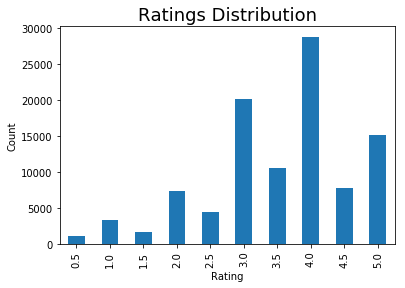

In [8]:
#overall distribution of ratings 
import matplotlib.pyplot as plt
%matplotlib inline
count_ratings = pd.value_counts(ratings['rating'], sort = False).sort_index()
count_ratings.plot(kind = 'bar')
plt.rc("font",size=15)
plt.title("Ratings Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

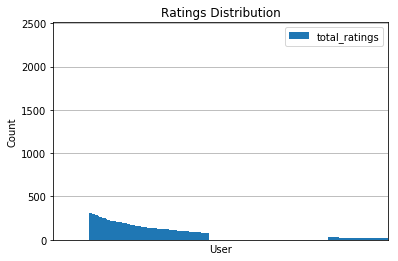

In [11]:
import operator
A=ratings.groupby(['userId']).userId.count()
agg_ratings=list(A)
user_Id=range(1,672)
dict_pair=dict(zip(user_Id,agg_ratings))
#print dict_pair
#sorted_agg_ratings = sorted(dict_pair.items(), key=operator.itemgetter(1),reverse=True)
#print sorted_agg_ratings
agg_ratings_sorted=sorted(agg_ratings, reverse=True)
#print agg_ratings_sorted
agg_ratings_df = pd.DataFrame({'total_ratings':agg_ratings_sorted})
#print (agg_ratings_df)
#agg_ratings_df.to_csv('agg_ratings_df.csv')
import matplotlib.pyplot as plt
%matplotlib inline
#count_ratings = pd.value_counts(ratings['rating'], sort = False).sort_index()
p=agg_ratings_df.plot(kind = 'bar')
p.axes.get_xaxis().set_ticks([])
plt.rc("font",size=10)
plt.title("Ratings Distribution")
plt.xlabel("User")
plt.ylabel("Count")
plt.grid()
plt.show()

In [32]:
#Every customer has rated a movie only once
ratings.groupby(['userId','movieId']).userId.count().value_counts()

1    100004
Name: userId, dtype: int64

In [33]:
#converting time since epoch to datetime 
ratings["timestamp"] = pd.to_datetime(ratings['timestamp'], unit='ms')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1970-01-15 14:12:39.144
1,1,1029,3.0,1970-01-15 14:12:39.179
2,1,1061,3.0,1970-01-15 14:12:39.182
3,1,1129,2.0,1970-01-15 14:12:39.185
4,1,1172,4.0,1970-01-15 14:12:39.205


The ratings data consists of 671 users who have rated a total of 9066 movies. The rating is in a range of 0.5 to 5 with an increment of 0.5. Each user has rated a particular movie only once. 

## Explaoring Tags data

In [34]:
#checking tags data 
tags.head()

,userId,movieId,tag,timestamp
0,15,339,sandra 'boring' bullock,1138537770
1,15,1955,dentist,1193435061
2,15,7478,Cambodia,1170560997
3,15,32892,Russian,1170626366
4,15,34162,forgettable,1141391765


In [35]:
#converting time since epoch to datetime 
tags["timestamp"] = pd.to_datetime(tags['timestamp'], unit='ms')
tags.head()

,userId,movieId,tag,timestamp
0,15,339,sandra 'boring' bullock,1970-01-14 04:15:37.770
1,15,1955,dentist,1970-01-14 19:30:35.061
2,15,7478,Cambodia,1970-01-14 13:09:20.997
3,15,32892,Russian,1970-01-14 13:10:26.366
4,15,34162,forgettable,1970-01-14 05:03:11.765


In [36]:
#shape of tags data
tags_shape = tags.shape
print("Shape of tags dataset = {}".format(tags_shape))

Shape of tags dataset = (1296, 4)


In [37]:
#No of unique values in tags dataset
m = tags.nunique()
uni_user = m[0]
uni_movies = m[1]
uni_tags = m[2]
print("No of unique users who have tagged a movie = {} ".format(uni_user))
print("No of unique movies that have been tagged = {} ".format(uni_movies))
print("No of unique values of tags = {} ".format(uni_tags))

No of unique users who have tagged a movie = 61 
No of unique movies that have been tagged = 689 
No of unique values of tags = 582 


In [38]:
#checking Null values in the tags dataset
tags.isnull().any()

userId       False
movieId      False
tag          False
timestamp    False
dtype: bool

In [39]:
#looking at data with more than 5 tags for a movie
df = tags.groupby(['userId','movieId']).count()
df.loc[df['tag'] > 5].head()

tag  timestamp
userId movieId                
138    48780      6          6
       79132      7          7
       109487    12         12
212    64957      8          8
       66097      7          7

In [40]:
#creating combined tag for a particular user movie combination
tags_new =tags.groupby(['userId','movieId'], as_index=False).sum()

In [41]:
tags_new.head()

,userId,movieId,tag
0,15,339,sandra 'boring' bullock
1,15,1955,dentist
2,15,7478,Cambodia
3,15,32892,Russian
4,15,34162,forgettable


In [42]:
#New shape of tags dataset
tags_shape = tags_new.shape
print("shape of tags dataset = {}".format(tags_shape))

shape of tags dataset = (772, 3)


## Merging ratings and tags data - User level Information

In [43]:
#merging the ratings and tags data : information at user level
ratings_tags = pd.merge(ratings,tags_new[['userId','movieId','tag']],how = 'left', left_on = ['userId','movieId'], right_on = ['userId','movieId'])

In [44]:
#shape of the new ratings _tags dataset
ratings_tags_shape = ratings_tags.shape
print("shape of ratings_tags dataset = {}".format(ratings_tags_shape))

shape of ratings_tags dataset = (100004, 5)


In [45]:
#checking data for a particular entry
ratings_tags.loc[(ratings_tags.userId == 15) & (ratings_tags.movieId == 339)]

,userId,movieId,rating,timestamp,tag
1048,15,339,2.5,1970-01-13 23:49:36.622,sandra 'boring' bullock


In [46]:
#storing ratings and tags data as Sframe
ratings_tags.to_csv("ratings_tags.csv")
user_metadata = graphlab.SFrame.read_csv('ratings_tags.csv' )

Finished parsing file C:\Users\hp\Desktop\Jupyter Notebooks\Personalisation-master\Personalisation-master\ratings_tags.csv

Parsing completed. Parsed 100 lines in 0.1351 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[long,long,long,float,str,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file C:\Users\hp\Desktop\Jupyter Notebooks\Personalisation-master\Personalisation-master\ratings_tags.csv

Parsing completed. Parsed 100004 lines in 0.148604 secs.

## Combining all datasets to create the final data

In [47]:
#Including the movie information to the ratings_tags data
all_data = pd.merge(ratings_tags, movies_links,how = 'left', left_on = ['movieId'], right_on = ['movieId'])

In [48]:
#checking the head of the combined data
all_data.head()

,userId,movieId,rating,timestamp,tag,title,genres,genres1,genres2,genres3,genres4,genres5,genres6,genres7,genres8,genres9,genres10,Year_release,imdbId,tmdbId
0,1,31,2.5,1970-01-15 14:12:39.144,NaN,Dangerous Minds (1995),Drama,Drama,None,None,None,None,None,None,None,None,None,1995,112792,9909.0
1,1,1029,3.0,1970-01-15 14:12:39.179,NaN,Dumbo (1941),Animation|Children|Drama|Musical,Animation,Children,Drama,Musical,None,None,None,None,None,None,1941,33563,11360.0
2,1,1061,3.0,1970-01-15 14:12:39.182,NaN,Sleepers (1996),Thriller,Thriller,None,None,None,None,None,None,None,None,None,1996,117665,819.0
3,1,1129,2.0,1970-01-15 14:12:39.185,NaN,Escape from New York (1981),Action|Adventure|Sci-Fi|Thriller,Action,Adventure,Sci-Fi,Thriller,None,None,None,None,None,None,1981,82340,1103.0
4,1,1172,4.0,1970-01-15 14:12:39.205,NaN,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama,Drama,None,None,None,None,None,None,None,None,None,1989,95765,11216.0


In [49]:
#shape of the combined data
all_data_shape = all_data.shape
print("shape of combined dataset = {}".format(all_data_shape))

shape of combined dataset = (100004, 20)


In [50]:
#converting the tags column to string type
all_data['tag'] = all_data['tag'].astype(str)

In [51]:
#checking data type of all columns 
all_data.dtypes

userId                   int64
movieId                  int64
rating                 float64
timestamp       datetime64[ns]
tag                     object
title                   object
genres                  object
genres1                 object
genres2                 object
genres3                 object
genres4                 object
genres5                 object
genres6                 object
genres7                 object
genres8                 object
genres9                 object
genres10                object
Year_release            object
imdbId                   int64
tmdbId                 float64
dtype: object

# Model based recommendation with Graphlabs

In [59]:
#splitting the data into test and train 80/20
train_data, test_data  = train_test_split(all_data , test_size=0.2, random_state=42)

In [60]:
#shape of train data
train_shape = train_data.shape
print("shape of train dataset = {}".format(train_shape))

shape of train dataset = (80003, 20)


In [61]:
#No of unique values in train data
m = train_data.nunique()
uni_user = m[0]
uni_movies = m[1]
uni_ratings = m[2]
print("No of unique users who have rated a movie = {} ".format(uni_user))
print("No of unique movies that have been rated = {} ".format(uni_movies))
print("No of unique values of ratings = {} ".format(uni_ratings))

No of unique users who have rated a movie = 671 
No of unique movies that have been rated = 8399 
No of unique values of ratings = 10 


In [62]:
#shape of test dataset
test_shape = test_data.shape
print("shape of train dataset = {}".format(test_shape))

shape of train dataset = (20001, 20)


In [63]:
#No of unique values in test data
m = test_data.nunique()
uni_user = m[0]
uni_movies = m[1]
uni_ratings = m[2]
print("No of unique users who have rated a movie = {} ".format(uni_user))
print("No of unique movies that have been rated = {} ".format(uni_movies))
print("No of unique values of ratings = {} ".format(uni_ratings))

No of unique users who have rated a movie = 671 
No of unique movies that have been rated = 4901 
No of unique values of ratings = 10 


In [68]:
#Keeping a copy of the test and train dataframes to use for sampling later
trainData = train_data
testData = test_data
#verifying
print(trainData.shape)
print(testData.shape)

(80003, 20)
(20001, 20)


In [69]:
#exporting the test and train dataset to csv 
train_data.to_csv('train_data.csv')
test_data.to_csv('test_data.csv')

In [71]:
#converting the test and train dataset to Sframe
hints = [int,int ,int ,float,str, str, str, str, str, str,str,str,str,str,str,str, str,str,float, int, float]
train = graphlab.SFrame.read_csv('train_data.csv',column_type_hints = hints )
test = graphlab.SFrame.read_csv('test_data.csv',column_type_hints = hints )

Finished parsing file C:\Users\hp\Desktop\Jupyter Notebooks\Personalisation-master\Personalisation-master\train_data.csv

Parsing completed. Parsed 80003 lines in 0.425811 secs.

Finished parsing file C:\Users\hp\Desktop\Jupyter Notebooks\Personalisation-master\Personalisation-master\test_data.csv

Parsing completed. Parsed 20001 lines in 0.111292 secs.

Using the follwoing three approaches to solve the regression.
* Adaptive Gradient Stochastic Gradient Descent
* Stochastic Gradient Descent
* Alternating Least Squares

In [ ]:
Tuning the 'Solver' parameter:

In [257]:
#Using adaptive gradient stochastic descent 
m1 = graphlab.factorization_recommender.create(train, target='rating', user_id='userId', 
                                               item_id='movieId',solver= "adagrad" , user_data = user_metadata, 
                                               item_data = movie_metadata, num_factors=4)

Recsys training: model = factorization_recommender

Preparing data set.

Data has 80004 observations with 671 users and 9125 items.

Data prepared in: 0.817622s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 1e-008   |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 80004 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 1.21951           | Not Viable                               |

| 1       | 0.304878          | Not Viable                               |

| 2       | 0.0762195         | 0.142317                                 |

| 3       | 0.0381098         | 0.209166                                 |

| 4       | 0.0190549         | 0.345443                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.0762195         | 0.142317                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 501us        | 1.13362           | 1.06471               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 289.214ms    | 0.90004           | 0.948688              | 0.0762195   |

| 2       | 621.951ms    | 0.579026          | 0.760916              | 0.0762195   |

| 3       | 888.638ms    | 0.440058          | 0.66334               | 0.0762195   |

| 4       | 1.13s        | 0.356746          | 0.597246              | 0.0762195   |

| 5       | 1.45s        | 0.29896           | 0.546728              | 0.0762195   |

| 6       | 1.71s        | 0.253861          | 0.503794              | 0.0762195   |

| 10      | 2.83s        | 0.149613          | 0.386709              | 0.0762195   |

| 11      | 3.14s        | 0.133534          | 0.365324              | 0.0762195   |

| 15      | 4.30s        | 0.0880508         | 0.296594              | 0.0762195   |

| 20      | 5.71s        | 0.0578569         | 0.240344              | 0.0762195   |

| 25      | 7.15s        | 0.0416145         | 0.203756              | 0.0762195   |

| 30      | 8.26s        | 0.0326064         | 0.180289              | 0.0762195   |

| 35      | 9.31s        | 0.0262197         | 0.161599              | 0.0762195   |

| 40      | 10.29s       | 0.0221742         | 0.148548              | 0.0762195   |

| 45      | 11.30s       | 0.0192449         | 0.13833               | 0.0762195   |

| 50      | 12.28s       | 0.0170617         | 0.130195              | 0.0762195   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0196614

Final training RMSE: 0.139823

In [258]:
#Using stochastic gradient descent 
m2 = graphlab.factorization_recommender.create(train, target='rating', user_id='userId', item_id='movieId', 
                                               user_data = user_metadata, item_data = movie_metadata ,
                                               solver= "sgd" , num_factors=4)


Recsys training: model = factorization_recommender

Preparing data set.

Data has 80004 observations with 671 users and 9125 items.

Data prepared in: 0.828639s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 1e-008   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 80004 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 1.21951           | Not Viable                               |

| 1       | 0.304878          | Not Viable                               |

| 2       | 0.0762195         | Not Viable                               |

| 3       | 0.0190549         | Not Viable                               |

| 4       | 0.00476372        | 0.748272                                 |

| 5       | 0.00238186        | 0.801807                                 |

| 6       | 0.00119093        | 0.862337                                 |

| 7       | 0.000595465       | 0.922701                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.00476372        | 0.748272                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 1.13364           | 1.06472               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 296.716ms    | DIVERGED          | DIVERGED              | 0.00476372  |

| RESET   | 376.272ms    | 1.13351           | 1.06466               |             |

| 1       | 653.469ms    | DIVERGED          | DIVERGED              | 0.00238186  |

| RESET   | 744.033ms    | 1.13357           | 1.06469               |             |

| 1       | 940.171ms    | 1.03667           | 1.01817               | 0.00119093  |

| 2       | 1.09s        | 0.869429          | 0.932432              | 0.000708131 |

| 3       | 1.27s        | 0.83924           | 0.9161                | 0.000522451 |

| 4       | 1.53s        | 0.805275          | 0.897371              | 0.000421057 |

| 5       | 1.77s        | 0.805123          | 0.897287              | 0.000356171 |

| 6       | 1.95s        | 0.834335          | 0.913419              | 0.000310651 |

| 8       | 2.35s        | 0.772065          | 0.878672              | 0.000177033 |

| 11      | 2.97s        | 0.751733          | 0.867025              |             |

| 13      | 3.35s        | 0.787718          | 0.887535              |             |

| 18      | 4.34s        | 0.86531           | 0.93022               |             |

| 23      | 5.25s        | 0.881704          | 0.938991              |             |

| 28      | 5.95s        | 0.883365          | 0.939875              |             |

| 33      | 6.77s        | 0.883773          | 0.940092              |             |

| 38      | 7.46s        | 0.883501          | 0.939947              |             |

| 43      | 8.25s        | 0.883492          | 0.939942              |             |

| 48      | 9.00s        | 0.883113          | 0.939741              | 2.8691e-009 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.882943

Final training RMSE: 0.93965

In [259]:
#Using Implicit Alternating Least Squares 
m3 = graphlab.factorization_recommender.create(train, target='rating', user_id='userId',
                                               item_id='movieId',solver= "als" ,user_data = user_metadata,
                                               item_data = movie_metadata , num_factors=4)


Recsys training: model = factorization_recommender

Warning: This solver currently does not support side features. Proceeding with training without side features.

Preparing data set.

Data has 80004 observations with 547 users and 7950 items.

Data prepared in: 0.540398s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 4        |

| regularization               | L2 Regularization on Factors                     | 1e-008   |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 0us          | NA                     |

+---------+--------------+------------------------+

| 0       | 160.124ms    | 0.868927               |

| 1       | 234.176ms    | 0.828776               |

| 2       | 318.736ms    | 0.809089               |

| 3       | 397.292ms    | 0.796711               |

| 4       | 479.351ms    | 0.786859               |

| 5       | 561.407ms    | 0.777935               |

| 6       | 634.46ms     | 0.770774               |

| 7       | 718.019ms    | 0.764788               |

| 8       | 803.08ms     | 0.759848               |

| 9       | 908.153ms    | 0.756008               |

| 10      | 1.01s        | 0.752738               |

| 11      | 1.09s        | 0.749811               |

| 12      | 1.18s        | 0.747065               |

| 13      | 1.26s        | 0.744589               |

| 14      | 1.34s        | 0.742308               |

| 15      | 1.42s        | 0.740174               |

| 16      | 1.51s        | 0.738229               |

| 17      | 1.61s        | 0.736685               |

| 18      | 1.71s        | 0.735423               |

| 19      | 1.80s        | 0.734196               |

| 20      | 1.88s        | 0.733147               |

| 21      | 1.95s        | 0.732162               |

| 22      | 2.04s        | 0.731219               |

| 23      | 2.12s        | 0.730364               |

| 24      | 2.22s        | 0.729586               |

| 25      | 2.33s        | 0.728882               |

| 26      | 2.43s        | 0.728234               |

| 27      | 2.51s        | 0.727602               |

| 28      | 2.59s        | 0.727009               |

| 29      | 2.67s        | 0.726458               |

| 30      | 2.76s        | 0.725954               |

| 31      | 2.86s        | 0.725493               |

| 32      | 2.96s        | 0.725027               |

| 33      | 3.06s        | 0.724625               |

| 34      | 3.13s        | 0.724242               |

| 35      | 3.21s        | 0.723861               |

| 36      | 3.30s        | 0.723487               |

| 37      | 3.39s        | 0.723113               |

| 38      | 3.47s        | 0.72276                |

| 39      | 3.56s        | 0.722421               |

| 40      | 3.64s        | 0.722084               |

| 41      | 3.72s        | 0.721749               |

| 42      | 3.80s        | 0.721404               |

| 43      | 3.89s        | 0.721039               |

| 44      | 3.99s        | 0.720682               |

| 45      | 4.08s        | 0.720287               |

| 46      | 4.15s        | 0.719848               |

| 47      | 4.23s        | 0.719476               |

| 48      | 4.31s        | 0.719109               |

| 49      | 4.39s        | 0.718778               |

| FINAL   | 4.39s        | 0.718778               |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Comparing the performance of the three models on the test data, to finalize the approach

In [262]:
model_comp1 = graphlab.compare(test, [m1,m2,m3],target='rating')
model_comp1_df = model_comp1.to_dataframe()
model_comp1_df.head()

PROGRESS: Evaluate model M0

Precision and recall summary statistics by cutoff
+--------+------------------+-------------------+
| cutoff |  mean_precision  |    mean_recall    |
+--------+------------------+-------------------+
|   1    |       0.0        |        0.0        |
|   2    |      0.004       | 9.75609756098e-06 |
|   3    | 0.00266666666667 | 9.75609756098e-06 |
|   4    |      0.006       | 0.000248083623693 |
|   5    |      0.0048      | 0.000248083623693 |
|   6    |      0.004       | 0.000248083623693 |
|   7    | 0.00342857142857 | 0.000248083623693 |
|   8    |      0.004       | 0.000257839721254 |
|   9    | 0.00355555555556 | 0.000257839721254 |
|   10   |      0.0032      | 0.000257839721254 |
+--------+------------------+-------------------+
[10 rows x 3 columns]

PROGRESS: Evaluate model M1

Precision and recall summary statistics by cutoff
+--------+-----------------+-------------------+
| cutoff |  mean_precision |    mean_recall    |
+--------+-----------

,dataset,metric,model,model_type,results
0,test,precision_recall,m1,FactorizationRecommender,"{u'precision_recall': [{u'cutoff': 1, u'precis..."
1,test,precision_recall,m2,FactorizationRecommender,"{u'precision_recall': [{u'cutoff': 1, u'precis..."
2,test,precision_recall,m3,FactorizationRecommender,"{u'precision_recall': [{u'cutoff': 1, u'precis..."


Comparing the models with varying solver paramaters:

PROGRESS: Evaluate model M0

Precision and recall summary statistics by cutoff
+--------+------------------+-------------------+
| cutoff |  mean_precision  |    mean_recall    |
+--------+------------------+-------------------+
|   1    |       0.0        |        0.0        |
|   2    |      0.004       | 9.75609756098e-06 |
|   3    | 0.00266666666667 | 9.75609756098e-06 |
|   4    |      0.006       | 0.000248083623693 |
|   5    |      0.0048      | 0.000248083623693 |
|   6    |      0.004       | 0.000248083623693 |
|   7    | 0.00342857142857 | 0.000248083623693 |
|   8    |      0.004       | 0.000257839721254 |
|   9    | 0.00355555555556 | 0.000257839721254 |
|   10   |      0.0032      | 0.000257839721254 |
+--------+------------------+-------------------+
[10 rows x 3 columns]

PROGRESS: Evaluate model M1

Precision and recall summary statistics by cutoff
+--------+-----------------+-------------------+
| cutoff |  mean_precision |    mean_recall    |
+--------+-----------

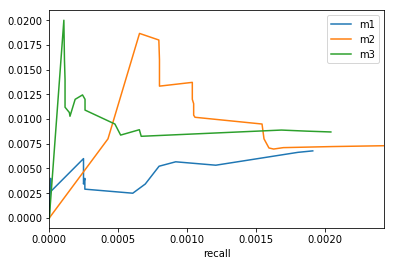

In [263]:
model_comp1 = graphlab.compare(test, [m1,m2,m3],target='rating')
model_comp1_df = model_comp1.to_dataframe()

fig, ax = plt.subplots(1, 1)
for i in range(0,len(model_comp1_df.index)):
    xy_dict= model_comp1_df.loc[i,"results"]['precision_recall']
    xy = pd.DataFrame(xy_dict)        
    label1= model_comp1_df.loc[i,"model"]
    xy.plot(x='recall',y= 'precision',ax=ax,label=label1)  
    
plt.show()


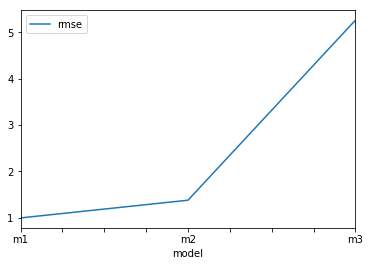

In [264]:
model_comp1 =graphlab.recommender.util.compare_models(test, [m1,m2,m3], model_names=None,
                                         user_sample=1.0, metric='rmse',
                                         target='rating', exclude_known_for_precision_recall=True, 
                                         make_plot=False, verbose=False)
rmse_data = {'model':['m1','m2','m3'], 'rmse':[]}
for i in range(0,len(model_comp1)):
    rmse_data['rmse'].append(model_comp1[i]['rmse_overall'])
    

rmse_df=pd.DataFrame(rmse_data)
rmse_df.plot(x='model',y='rmse')
plt.show()

Model performance for different values of L2 regularization

In [265]:
sgd_R2 = graphlab.factorization_recommender.create(train, target='rating', user_id='userId', item_id='movieId',user_data = user_metadata, item_data = movie_metadata,solver= "sgd" ,regularization=1e-08,num_factors=4)
sgd_R3 = graphlab.factorization_recommender.create(train, target='rating', user_id='userId', item_id='movieId',user_data = user_metadata, item_data = movie_metadata,solver= "sgd" ,regularization=1e-06,num_factors=4)
sgd_R4 = graphlab.factorization_recommender.create(train, target='rating', user_id='userId', item_id='movieId',user_data = user_metadata, item_data = movie_metadata,solver= "sgd" ,regularization=1e-04,num_factors=4)
sgd_R5 = graphlab.factorization_recommender.create(train, target='rating', user_id='userId', item_id='movieId',user_data = user_metadata, item_data = movie_metadata,solver= "sgd" ,regularization=1e-02,num_factors=4)

Recsys training: model = factorization_recommender

Preparing data set.

Data has 80004 observations with 671 users and 9125 items.

Data prepared in: 0.772235s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 1e-008   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 80004 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 1.21951           | Not Viable                               |

| 1       | 0.304878          | Not Viable                               |

| 2       | 0.0762195         | Not Viable                               |

| 3       | 0.0190549         | Not Viable                               |

| 4       | 0.00476372        | Not Viable                               |

| 5       | 0.00119093        | 0.935923                                 |

| 6       | 0.000595465       | 1.11289                                  |

| 7       | 0.000297732       | 1.00078                                  |

| 8       | 0.000148866       | 1.03413                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00119093        | 0.935923                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 1.13363           | 1.06472               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 289.707ms    | 0.999089          | 0.999544              | 0.00119093  |

| 2       | 509.864ms    | 0.906603          | 0.952157              | 0.000708131 |

| 3       | 730.079ms    | 0.868804          | 0.932097              | 0.000522451 |

| 4       | 930.221ms    | 0.828805          | 0.910388              | 0.000421057 |

| 5       | 1.11s        | 0.803079          | 0.896147              | 0.000356171 |

| 6       | 1.36s        | 0.786025          | 0.886581              | 0.000310651 |

| 10      | 2.25s        | 0.766091          | 0.875266              | 0.000211781 |

| 11      | 2.44s        | 0.757135          | 0.870135              | 0.00019717  |

| 15      | 3.24s        | 0.733755          | 0.856595              | 0.000131389 |

| 20      | 4.24s        | 0.744371          | 0.862769              |             |

| 25      | 5.22s        | 0.762007          | 0.87293               |             |

| 30      | 6.23s        | 0.763441          | 0.873751              |             |

| 35      | 7.21s        | 0.764636          | 0.874435              |             |

| 40      | 7.99s        | 0.76546           | 0.874906              | 1.3158e-007 |

| 45      | 8.98s        | 0.765754          | 0.875073              |             |

| 50      | 9.95s        | 0.765416          | 0.87488               |             |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.765449

Final training RMSE: 0.874899

Recsys training: model = factorization_recommender

Preparing data set.

Data has 80004 observations with 671 users and 9125 items.

Data prepared in: 0.702545s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 1e-006   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 80004 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 1.21951           | Not Viable                               |

| 1       | 0.304878          | Not Viable                               |

| 2       | 0.0762195         | Not Viable                               |

| 3       | 0.0190549         | Not Viable                               |

| 4       | 0.00476372        | Not Viable                               |

| 5       | 0.00119093        | 0.995886                                 |

| 6       | 0.000595465       | 0.9713                                   |

| 7       | 0.000297732       | 0.99448                                  |

| 8       | 0.000148866       | 1.01715                                  |

| 9       | 7.44331e-005      | 1.04745                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.000595465       | 0.9713                                   |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 1.13358           | 1.0647                |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 236.986ms    | 0.982749          | 0.991337              | 0.000595465 |

| 2       | 491.667ms    | 0.908175          | 0.952982              | 0.000354066 |

| 3       | 693.81ms     | 0.873182          | 0.934441              | 0.000261225 |

| 4       | 908.462ms    | 0.898392          | 0.947835              | 0.000210529 |

| 5       | 1.12s        | 0.863121          | 0.929042              | 0.000149752 |

| 6       | 1.31s        | 0.841358          | 0.917254              | 0.000109832 |

| 10      | 2.10s        | 0.82726           | 0.909536              |             |

| 11      | 2.32s        | 0.842756          | 0.918015              |             |

| 15      | 3.08s        | 0.797453          | 0.892998              |             |

| 20      | 4.02s        | 0.786232          | 0.886693              |             |

| 25      | 4.93s        | 0.781765          | 0.88417               |             |

| 30      | 5.78s        | 0.781222          | 0.883863              |             |

| 35      | 6.46s        | 0.78028           | 0.88333               |             |

| 40      | 7.43s        | 0.780111          | 0.883234              |             |

| 45      | 8.41s        | 0.779886          | 0.883107              |             |

| 50      | 9.28s        | 0.779894          | 0.883111              |             |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.779856

Final training RMSE: 0.88309

Recsys training: model = factorization_recommender

Preparing data set.

Data has 80004 observations with 671 users and 9125 items.

Data prepared in: 0.81867s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 80004 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 1.21951           | Not Viable                               |

| 1       | 0.304878          | Not Viable                               |

| 2       | 0.0762195         | Not Viable                               |

| 3       | 0.0190549         | Not Viable                               |

| 4       | 0.00476372        | 0.782938                                 |

| 5       | 0.00238186        | 0.789769                                 |

| 6       | 0.00119093        | 0.847013                                 |

| 7       | 0.000595465       | 0.910558                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.00476372        | 0.782938                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 1.13359           | 1.0647                |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 285.702ms    | DIVERGED          | DIVERGED              | 0.00476372  |

| RESET   | 369.761ms    | 1.13376           | 1.06478               |             |

| 1       | 576.408ms    | DIVERGED          | DIVERGED              | 0.00238186  |

| RESET   | 670.974ms    | 1.13387           | 1.06483               |             |

| 1       | 855.105ms    | 1.04527           | 1.02239               | 0.00119093  |

| 2       | 1.03s        | 0.914222          | 0.956148              | 0.000708131 |

| 3       | 1.19s        | 0.832213          | 0.912254              | 0.000522451 |

| 4       | 1.36s        | 0.812407          | 0.901329              | 0.000421057 |

| 5       | 1.50s        | 0.805896          | 0.897703              | 0.000356171 |

| 6       | 1.67s        | 0.793178          | 0.890579              | 0.000310651 |

| 8       | 1.98s        | 0.771116          | 0.878069              | 0.000210529 |

| 11      | 2.40s        | 0.749994          | 0.865897              | 0.000117238 |

| 18      | 3.32s        | 0.757033          | 0.869802              |             |

| 28      | 4.72s        | 0.748913          | 0.865077              |             |

| 38      | 6.23s        | 0.74963           | 0.865486              |             |

| 48      | 7.55s        | 0.749552          | 0.86544               |             |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.749576

Final training RMSE: 0.865454

Recsys training: model = factorization_recommender

Preparing data set.

Data has 80004 observations with 671 users and 9125 items.

Data prepared in: 0.785614s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 80004 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0920564         | Not Viable                               |

| 1       | 0.0230141         | Not Viable                               |

| 2       | 0.00575353        | Not Viable                               |

| 3       | 0.00143838        | 0.921741                                 |

| 4       | 0.000719191       | No Decrease (21.1296 >= 1.12742)         |

| 5       | 0.000179798       | 1.01247                                  |

| 6       | 8.98988e-005      | 1.0215                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.00143838        | 0.921741                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 500us        | 1.13369           | 1.06475               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 319.727ms    | DIVERGED          | DIVERGED              | 0.00143838  |

| RESET   | 410.791ms    | 1.13392           | 1.06486               |             |

| 1       | 573.906ms    | 1.0158            | 1.00707               | 0.000719191 |

| 2       | 769.548ms    | 0.879524          | 0.935804              | 0.000427633 |

| 3       | 970.688ms    | 0.855644          | 0.92081               | 0.000315503 |

| 4       | 1.15s        | 0.885007          | 0.934774              | 0.000254272 |

| 5       | 1.32s        | 0.84571           | 0.912161              | 0.000180867 |

| 6       | 1.51s        | 0.88678           | 0.930116              | 0.000132653 |

| 9       | 1.94s        | 0.825573          | 0.894812              |             |

| 11      | 2.21s        | 0.822321          | 0.891811              |             |

| 19      | 3.22s        | 0.82529           | 0.890583              |             |

| 29      | 4.55s        | 0.825237          | 0.889807              |             |

| 39      | 5.77s        | 0.825537          | 0.889899              |             |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 0.825584

Final training RMSE: 0.889914

PROGRESS: Evaluate model M0

Precision and recall summary statistics by cutoff
+--------+------------------+-------------------+
| cutoff |  mean_precision  |    mean_recall    |
+--------+------------------+-------------------+
|   1    |       0.0        |        0.0        |
|   2    |      0.004       | 4.61095100865e-06 |
|   3    | 0.00533333333333 | 0.000140204171348 |
|   4    |       0.01       | 0.000497131907132 |
|   5    |      0.008       | 0.000497131907132 |
|   6    |      0.008       | 0.000506888004693 |
|   7    |      0.008       | 0.000516644102254 |
|   8    |      0.007       | 0.000516644102254 |
|   9    | 0.00711111111111 | 0.000526400199815 |
|   10   |      0.0072      | 0.000542273215688 |
+--------+------------------+-------------------+
[10 rows x 3 columns]

PROGRESS: Evaluate model M1

Precision and recall summary statistics by cutoff
+--------+-----------------+-------------------+
| cutoff |  mean_precision |    mean_recall    |
+--------+-----------

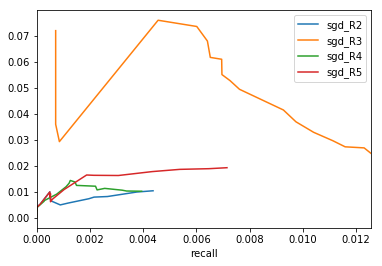

       area   model
0  0.120680  sgd_R2
1  0.806674  sgd_R3
2  0.159381  sgd_R4
3  0.190239  sgd_R5


In [243]:
model_comp1 = graphlab.compare(test, [sgd_R2,sgd_R3,sgd_R4,sgd_R5],target='rating')
model_comp1_df = model_comp1.to_dataframe()

fig, ax = plt.subplots(1, 1)
auc={'model':[], 'area':[]}
for i in range(0,len(model_comp1_df.index)):
    xy_dict= model_comp1_df.loc[i,"results"]['precision_recall']
    xy = pd.DataFrame(xy_dict)    
    #xy.plot(x='recall',y= 'precision',ax=ax)
    label1= model_comp1_df.loc[i,"model"]
    xy.plot(x='recall',y= 'precision',ax=ax,label=label1)
    auc['model'].append(label1)
    auc['area'].append(np.trapz(xy['precision']))
    
plt.show()
auc_df= pd.DataFrame(auc)
print(auc_df)

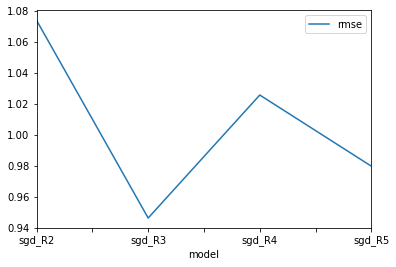

In [266]:
model_comp1 =graphlab.recommender.util.compare_models(test, [sgd_R2,sgd_R3,sgd_R4,sgd_R5], model_names=None,
                                         user_sample=1.0, metric='rmse',
                                         target='rating', exclude_known_for_precision_recall=True, 
                                         make_plot=False, verbose=False)

rmse_data = {'model':['sgd_R2','sgd_R3','sgd_R4','sgd_R5'], 'rmse':[]}
for i in range(0,len(model_comp1)):
    rmse_data['rmse'].append(model_comp1[i]['rmse_overall'])
    

rmse_df=pd.DataFrame(rmse_data)
rmse_df.plot(x='model',y='rmse')
plt.show()

Changing number of factors in the model

In [267]:
sgd_NF1 = graphlab.factorization_recommender.create(train, target='rating', user_id='userId', item_id='movieId',user_data = user_metadata, item_data = movie_metadata,solver= "sgd" ,regularization=1e-06,num_factors=2)
sgd_NF2 = graphlab.factorization_recommender.create(train, target='rating', user_id='userId', item_id='movieId',user_data = user_metadata, item_data = movie_metadata,solver= "sgd" ,regularization=1e-06,num_factors=4)
sgd_NF3 = graphlab.factorization_recommender.create(train, target='rating', user_id='userId', item_id='movieId',user_data = user_metadata, item_data = movie_metadata,solver= "sgd" ,regularization=1e-06,num_factors=6)


Recsys training: model = factorization_recommender

Preparing data set.

Data has 80004 observations with 671 users and 9125 items.

Data prepared in: 0.776716s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 1e-006   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 80004 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 1.21951           | Not Viable                               |

| 1       | 0.304878          | Not Viable                               |

| 2       | 0.0762195         | Not Viable                               |

| 3       | 0.0190549         | Not Viable                               |

| 4       | 0.00476372        | 0.741318                                 |

| 5       | 0.00238186        | 0.78254                                  |

| 6       | 0.00119093        | 0.867571                                 |

| 7       | 0.000595465       | 0.925974                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.00476372        | 0.741318                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 1.13363           | 1.06472               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 320.738ms    | DIVERGED          | DIVERGED              | 0.00476372  |

| RESET   | 398.793ms    | 1.13369           | 1.06475               |             |

| 1       | 632.458ms    | DIVERGED          | DIVERGED              | 0.00238186  |

| RESET   | 718.992ms    | 1.13352           | 1.06467               |             |

| 1       | 903.122ms    | 1.08429           | 1.04129               | 0.00119093  |

| 2       | 1.06s        | 0.888456          | 0.942578              | 0.000708131 |

| 3       | 1.24s        | 0.834573          | 0.913548              | 0.000522451 |

| 4       | 1.47s        | DIVERGED          | DIVERGED              | 0.000421057 |

| RESET   | 1.55s        | 1.1333            | 1.06457               |             |

| 1       | 1.73s        | 0.986667          | 0.993311              | 0.000210529 |

| 2       | 1.90s        | 0.938156          | 0.968584              | 0.000125181 |

| 3       | 2.07s        | 0.923733          | 0.96111               |             |

| 4       | 2.24s        | 0.908975          | 0.953402              |             |

| 8       | 2.79s        | 0.872623          | 0.934143              |             |

| 9       | 2.96s        | 0.872943          | 0.934314              |             |

| 14      | 3.65s        | 0.875092          | 0.935463              | 1.4544e-005 |

| 19      | 4.32s        | 0.875968          | 0.935931              |             |

| 24      | 5.00s        | 0.879192          | 0.937651              |             |

| 29      | 5.69s        | 0.878119          | 0.937079              |             |

| 34      | 6.37s        | 0.878039          | 0.937036              | 2.2095e-007 |

| 39      | 7.05s        | 0.878138          | 0.937089              |             |

| 44      | 7.76s        | 0.877948          | 0.936988              |             |

| 48      | 8.30s        | 0.877945          | 0.936986              |             |

| 49      | 8.45s        | 0.877922          | 0.936974              |             |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached (hard limit).

Computing final objective value and training RMSE.

Final objective value: 0.877937

Final training RMSE: 0.936982

Recsys training: model = factorization_recommender

Preparing data set.

Data has 80004 observations with 671 users and 9125 items.

Data prepared in: 1.22437s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 1e-006   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 80004 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 1.21951           | Not Viable                               |

| 1       | 0.304878          | Not Viable                               |

| 2       | 0.0762195         | Not Viable                               |

| 3       | 0.0190549         | Not Viable                               |

| 4       | 0.00476372        | Not Viable                               |

| 5       | 0.00119093        | 0.870239                                 |

| 6       | 0.000595465       | 0.947289                                 |

| 7       | 0.000297732       | 0.993597                                 |

| 8       | 0.000148866       | 1.01165                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00119093        | 0.870239                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 500us        | 1.13363           | 1.06472               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 265.687ms    | 1.02859           | 1.01419               | 0.00119093  |

| 2       | 594.922ms    | 0.888013          | 0.942344              | 0.000708131 |

| 3       | 814.076ms    | 0.849051          | 0.921439              | 0.000522451 |

| 4       | 1.00s        | 0.808073          | 0.898928              | 0.000421057 |

| 5       | 1.19s        | 0.794189          | 0.891172              | 0.000356171 |

| 6       | 1.42s        | 0.78903           | 0.888273              | 0.000310651 |

| 10      | 2.23s        | 0.749362          | 0.865655              | 0.000149752 |

| 11      | 2.39s        | 0.742143          | 0.861475              | 0.000117238 |

| 15      | 3.00s        | 0.7413            | 0.860984              |             |

| 20      | 3.72s        | 0.75727           | 0.870208              |             |

| 25      | 4.45s        | 0.772339          | 0.878823              |             |

| 30      | 5.19s        | 0.772929          | 0.879159              |             |

| 35      | 5.93s        | 0.773317          | 0.87938               |             |

| 40      | 6.78s        | 0.773562          | 0.879519              |             |

| 45      | 7.84s        | 0.773635          | 0.87956               |             |

| 50      | 8.81s        | 0.773647          | 0.879567              |             |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.773654

Final training RMSE: 0.879571

Recsys training: model = factorization_recommender

Preparing data set.

Data has 80004 observations with 671 users and 9125 items.

Data prepared in: 0.743758s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 1e-006   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 80004 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 1.21951           | Not Viable                               |

| 1       | 0.304878          | Not Viable                               |

| 2       | 0.0762195         | Not Viable                               |

| 3       | 0.0190549         | Not Viable                               |

| 4       | 0.00476372        | Not Viable                               |

| 5       | 0.00119093        | 0.91056                                  |

| 6       | 0.000595465       | 0.940354                                 |

| 7       | 0.000297732       | 0.997918                                 |

| 8       | 0.000148866       | 1.01573                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00119093        | 0.91056                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 1.1336            | 1.06471               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 247.188ms    | 1.13548           | 1.06559               | 0.00119093  |

| 2       | 446.33ms     | 0.876403          | 0.936163              | 0.000708131 |

| 3       | 663.484ms    | 0.821636          | 0.90644               | 0.000522451 |

| 4       | 869.13ms     | 0.796177          | 0.892286              | 0.000354066 |

| 5       | 1.09s        | 0.782477          | 0.884575              | 0.000299503 |

| 6       | 1.34s        | 0.766726          | 0.875626              | 0.000261225 |

| 10      | 2.24s        | 0.733206          | 0.856268              | 0.00010589  |

| 11      | 2.49s        | 0.729206          | 0.853929              |             |

| 15      | 3.28s        | 0.755476          | 0.869173              |             |

| 20      | 4.14s        | 0.785092          | 0.886046              |             |

| 25      | 5.32s        | 0.789586          | 0.888578              |             |

| 30      | 6.25s        | 0.791074          | 0.889415              |             |

| 35      | 7.08s        | 0.791131          | 0.889447              |             |

| 40      | 7.94s        | 0.790953          | 0.889347              |             |

| 45      | 9.10s        | 0.79081           | 0.889266              |             |

| 50      | 10.39s       | 0.790523          | 0.889105              |             |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.790497

Final training RMSE: 0.889091

PROGRESS: Evaluate model M0

Precision and recall summary statistics by cutoff
+--------+------------------+-------------------+
| cutoff |  mean_precision  |    mean_recall    |
+--------+------------------+-------------------+
|   1    |       0.0        |        0.0        |
|   2    |      0.004       | 9.75609756098e-06 |
|   3    | 0.00533333333333 |  1.9512195122e-05 |
|   4    |       0.01       | 0.000376439930906 |
|   5    |      0.0096      | 0.000386196028467 |
|   6    |      0.008       | 0.000386196028467 |
|   7    | 0.00685714285714 | 0.000386196028467 |
|   8    |      0.007       | 0.000395952126028 |
|   9    |      0.008       | 0.000753534310546 |
|   10   |      0.0072      | 0.000753534310546 |
+--------+------------------+-------------------+
[10 rows x 3 columns]

PROGRESS: Evaluate model M1

Precision and recall summary statistics by cutoff
+--------+-----------------+-------------------+
| cutoff |  mean_precision |    mean_recall    |
+--------+-----------

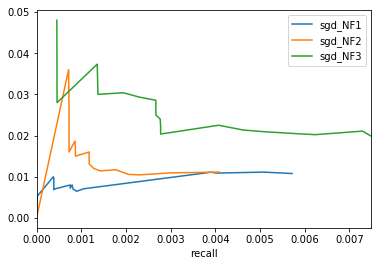

In [268]:
model_comp1 = graphlab.compare(test, [sgd_NF1,sgd_NF2,sgd_NF3],target='rating')
model_comp1_df = model_comp1.to_dataframe()
fig, ax = plt.subplots(1, 1)
for i in range(0,len(model_comp1_df.index)):
    xy_dict= model_comp1_df.loc[i,"results"]['precision_recall']
    xy = pd.DataFrame(xy_dict)    
    #xy.plot(x='recall',y= 'precision',ax=ax)
    label1= model_comp1_df.loc[i,"model"]
    xy.plot(x='recall',y= 'precision',ax=ax,label=label1)
    
plt.show()

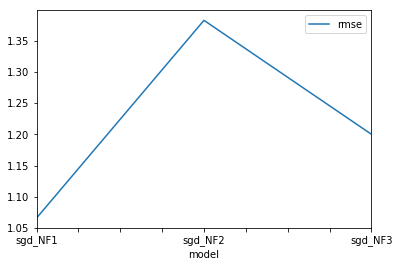

     model      rmse
0  sgd_NF1  1.066276
1  sgd_NF2  1.382492
2  sgd_NF3  1.200294


In [269]:
model_comp1 =graphlab.recommender.util.compare_models(test, [sgd_NF1,sgd_NF2,sgd_NF3], model_names=None,
                                         user_sample=1.0, metric='rmse',
                                         target='rating', exclude_known_for_precision_recall=True, 
                                         make_plot=False, verbose=False)
#fig, ax = plt.subplots(1, 1)
rmse_data = {'model':['sgd_NF1','sgd_NF2','sgd_NF3'], 'rmse':[]}
for i in range(0,len(model_comp1)):
    rmse_data['rmse'].append(model_comp1[i]['rmse_overall'])
    

rmse_df=pd.DataFrame(rmse_data)
rmse_df.plot(x='model',y='rmse')
plt.show()
print(rmse_df)

# Evaluating Model Performance For Different Sample Sizes

In [270]:
train_sample1 = trainData.sample(frac =0.25,replace =False)
train_sample2 = trainData.sample(frac =0.5,replace =False)
train_sample3 = trainData.sample(frac =0.75,replace =False)
print("Training sample-1 shape - {}".format(train_sample1.shape))
print("Training sample-2 shape - {}".format(train_sample2.shape))
print("Training sample-3 shape - {}".format(train_sample3.shape))

Training sample-1 shape - (20001, 20)
Training sample-2 shape - (40002, 20)
Training sample-3 shape - (60002, 20)


In [271]:
#converting data to csv for Sframe parsing
train_sample1.to_csv("train_data1.csv")
train_sample2.to_csv("train_data2.csv")
train_sample3.to_csv("train_data3.csv")

In [272]:
#converting the train datasets to Sframe
hints = [int,int ,int ,float,str, str, str, str, str, str,str,str,str,str,str,str, str,str,float, int, float]
train1 = graphlab.SFrame.read_csv('train_data1.csv',column_type_hints = hints )
train2 = graphlab.SFrame.read_csv('train_data2.csv',column_type_hints = hints )
train3 = graphlab.SFrame.read_csv('train_data3.csv',column_type_hints = hints )

Finished parsing file C:\Users\hp\Desktop\Jupyter Notebooks\Personalisation-master\Personalisation-master\train_data1.csv

Parsing completed. Parsed 20001 lines in 0.14912 secs.

Finished parsing file C:\Users\hp\Desktop\Jupyter Notebooks\Personalisation-master\Personalisation-master\train_data2.csv

Parsing completed. Parsed 40002 lines in 0.265736 secs.

Finished parsing file C:\Users\hp\Desktop\Jupyter Notebooks\Personalisation-master\Personalisation-master\train_data3.csv

Parsing completed. Parsed 60002 lines in 0.369281 secs.

Building a factorization_recommender model using the graphLab package with 6 latent factors
Using stochastic gradient descent 

In [253]:
m1_t1 = graphlab.factorization_recommender.create(train1, target='rating', user_id='userId',
                                               item_id='movieId',solver= "sgd" , user_data = user_metadata,
                                               item_data = movie_metadata,regularization=1e-06, num_factors=6)
m1_t2 = graphlab.factorization_recommender.create(train2, target='rating', user_id='userId',
                                               item_id='movieId',solver= "sgd" , user_data = user_metadata,
                                               item_data = movie_metadata, regularization=1e-06, num_factors=6)
m1_t3 = graphlab.factorization_recommender.create(train3, target='rating', user_id='userId',
                                               item_id='movieId',solver= "sgd" , user_data = user_metadata,
                                               item_data = movie_metadata,regularization=1e-06, num_factors=6)
m1 = graphlab.factorization_recommender.create(train, target='rating', user_id='userId',
                                               item_id='movieId',solver= "sgd" , user_data = user_metadata,
                                               item_data = movie_metadata,regularization=1e-06, num_factors=6)

Recsys training: model = factorization_recommender

Preparing data set.

Data has 20001 observations with 671 users and 9125 items.

Data prepared in: 0.553433s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 1e-006   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 20001 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 1.21951           | Not Viable                               |

| 1       | 0.304878          | Not Viable                               |

| 2       | 0.0762195         | Not Viable                               |

| 3       | 0.0190549         | Not Viable                               |

| 4       | 0.00476372        | Not Viable                               |

| 5       | 0.00119093        | 0.899264                                 |

| 6       | 0.000595465       | 0.939843                                 |

| 7       | 0.000297732       | 0.984808                                 |

| 8       | 0.000148866       | 1.00595                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00119093        | 0.899264                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 1.002ms      | 1.11661           | 1.0567                |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 91.07ms      | 1.07085           | 1.03482               | 0.00119093  |

| 2       | 202.149ms    | 0.932334          | 0.965575              | 0.000708131 |

| 3       | 273.698ms    | 0.886522          | 0.941553              | 0.000522451 |

| 4       | 361.76ms     | 0.867117          | 0.931191              | 0.000421057 |

| 5       | 431.812ms    | 0.850954          | 0.922472              | 0.000356171 |

| 6       | 540.388ms    | 0.834406          | 0.913458              | 0.000310651 |

| 11      | 970.193ms    | 0.796055          | 0.892219              | 0.00019717  |

| 25      | 2.24s        | 0.759079          | 0.87125               |             |

| 50      | 4.35s        | 0.762949          | 0.873468              |             |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.762804

Final training RMSE: 0.873385

Recsys training: model = factorization_recommender

Preparing data set.

Data has 40002 observations with 671 users and 9125 items.

Data prepared in: 0.922435s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 1e-006   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 40002 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 1.21951           | Not Viable                               |

| 1       | 0.304878          | Not Viable                               |

| 2       | 0.0762195         | Not Viable                               |

| 3       | 0.0190549         | Not Viable                               |

| 4       | 0.00476372        | 0.873607                                 |

| 5       | 0.00238186        | 0.905395                                 |

| 6       | 0.00119093        | 0.891182                                 |

| 7       | 0.000595465       | 0.948738                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.00476372        | 0.873607                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 1.13266           | 1.06426               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 196.139ms    | DIVERGED          | DIVERGED              | 0.00476372  |

| RESET   | 263.188ms    | 1.13228           | 1.06408               |             |

| 1       | 386.274ms    | 1.06486           | 1.03192               | 0.00238186  |

| 2       | 505.358ms    | 1.0223            | 1.01109               | 0.00141626  |

| 3       | 627.446ms    | 0.904153          | 0.950869              | 0.0010449   |

| 4       | 733.021ms    | 0.835576          | 0.914098              | 0.000842115 |

| 5       | 868.115ms    | 0.80357           | 0.89642               | 0.000712342 |

| 6       | 1.04s        | 0.800597          | 0.894759              | 0.000621302 |

| 9       | 1.48s        | 0.741349          | 0.861015              | 0.000458389 |

| 11      | 1.76s        | 0.747886          | 0.864801              | 0.000394341 |

| 19      | 2.77s        | 0.676162          | 0.822285              | 9.2535e-005 |

| 29      | 4.22s        | 0.713938          | 0.844941              |             |

| 39      | 5.65s        | 0.718862          | 0.84785               |             |

| 49      | 6.98s        | 0.720673          | 0.848917              |             |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.720085

Final training RMSE: 0.84857

Recsys training: model = factorization_recommender

Preparing data set.

Data has 60002 observations with 671 users and 9125 items.

Data prepared in: 1.07879s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 1e-006   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 60002 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 1.21951           | Not Viable                               |

| 1       | 0.304878          | Not Viable                               |

| 2       | 0.0762195         | Not Viable                               |

| 3       | 0.0190549         | Not Viable                               |

| 4       | 0.00476372        | 0.806251                                 |

| 5       | 0.00238186        | 0.790053                                 |

| 6       | 0.00119093        | 0.892234                                 |

| 7       | 0.000595465       | 0.93128                                  |

| 8       | 0.000297732       | 0.98214                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00238186        | 0.790053                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 1.11951           | 1.05807               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 273.693ms    | DIVERGED          | DIVERGED              | 0.00238186  |

| RESET   | 372.763ms    | 1.12011           | 1.05835               |             |

| 1       | 580.41ms     | 1.04402           | 1.02177               | 0.00119093  |

| 2       | 783.554ms    | 0.898831          | 0.948067              | 0.000708131 |

| 3       | 973.69ms     | 0.875978          | 0.935937              | 0.000522451 |

| 4       | 1.13s        | 0.823015          | 0.907202              | 0.000421057 |

| 5       | 1.34s        | 0.807619          | 0.898676              | 0.000356171 |

| 6       | 1.51s        | 0.806976          | 0.898318              | 0.000310651 |

| 9       | 2.02s        | 0.766711          | 0.87562               | 0.000229195 |

| 11      | 2.31s        | 0.785263          | 0.88615               | 0.0001658   |

| 19      | 3.36s        | 0.746339          | 0.863907              |             |

| 29      | 4.82s        | 0.748397          | 0.865097              |             |

| 39      | 6.17s        | 0.749368          | 0.865657              |             |

| 49      | 7.49s        | 0.749851          | 0.865936              |             |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.749842

Final training RMSE: 0.865931

Recsys training: model = factorization_recommender

Preparing data set.

Data has 80004 observations with 671 users and 9125 items.

Data prepared in: 0.663486s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 1e-006   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 80004 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 1.21951           | Not Viable                               |

| 1       | 0.304878          | Not Viable                               |

| 2       | 0.0762195         | Not Viable                               |

| 3       | 0.0190549         | Not Viable                               |

| 4       | 0.00476372        | Not Viable                               |

| 5       | 0.00119093        | 0.898995                                 |

| 6       | 0.000595465       | 0.929946                                 |

| 7       | 0.000297732       | 0.982113                                 |

| 8       | 0.000148866       | 1.01201                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00119093        | 0.898995                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 500us        | 1.13367           | 1.06474               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 392.779ms    | DIVERGED          | DIVERGED              | 0.00119093  |

| RESET   | 559.897ms    | 1.13343           | 1.06462               |             |

| 1       | 876.123ms    | 0.970462          | 0.98512               | 0.000595465 |

| 2       | 1.27s        | 0.911623          | 0.954789              | 0.000354066 |

| 3       | 1.63s        | 0.862096          | 0.928491              | 0.000261225 |

| 4       | 1.95s        | 0.844623          | 0.919034              | 0.000210529 |

| 5       | 2.36s        | 0.88769           | 0.942172              | 0.000178086 |

| 6       | 2.66s        | 0.847549          | 0.920624              | 0.000130613 |

| 9       | 3.41s        | 0.839972          | 0.9165                |             |

| 11      | 3.82s        | 0.798039          | 0.89333               |             |

| 14      | 4.39s        | 0.801132          | 0.895059              |             |

| 19      | 5.24s        | 0.802483          | 0.895813              |             |

| 24      | 6.12s        | 0.804065          | 0.896696              |             |

| 29      | 6.94s        | 0.804886          | 0.897153              |             |

| 34      | 7.79s        | 0.804956          | 0.897192              |             |

| 39      | 8.63s        | 0.804976          | 0.897203              |             |

| 44      | 9.47s        | 0.805012          | 0.897223              |             |

| 49      | 10.31s       | 0.805052          | 0.897246              |             |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.805057

Final training RMSE: 0.897249

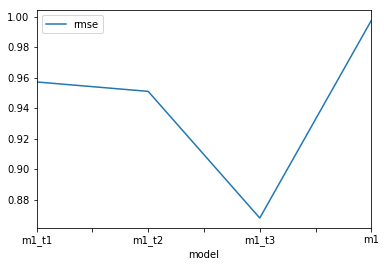

   model      rmse
0  m1_t1  0.957234
1  m1_t2  0.951057
2  m1_t3  0.867962
3     m1  0.997656


In [273]:
model_comp1 =graphlab.recommender.util.compare_models(test, [m1_t1,m1_t2,m1_t3,m1], model_names=None,
                                         user_sample=1.0, metric='rmse',
                                         target='rating', exclude_known_for_precision_recall=True, 
                                         make_plot=False, verbose=False)
#fig, ax = plt.subplots(1, 1)
rmse_data = {'model':["m1_t1","m1_t2","m1_t3","m1"], 'rmse':[]}
for i in range(0,len(model_comp1)):
    rmse_data['rmse'].append(model_comp1[i]['rmse_overall'])
    

rmse_df=pd.DataFrame(rmse_data)
rmse_df.plot(x='model',y='rmse')
plt.show()
print(rmse_df)

PROGRESS: Evaluate model M0

Precision and recall summary statistics by cutoff
+--------+------------------+-------------------+
| cutoff |  mean_precision  |    mean_recall    |
+--------+------------------+-------------------+
|   1    |       0.0        |        0.0        |
|   2    |      0.008       | 0.000211783696529 |
|   3    | 0.00533333333333 | 0.000211783696529 |
|   4    |       0.01       | 0.000568711432314 |
|   5    |      0.0096      | 0.000644901908504 |
|   6    |      0.012       | 0.000691310242717 |
|   7    | 0.0102857142857  | 0.000691310242717 |
|   8    |       0.01       | 0.000706724500906 |
|   9    | 0.0106666666667  |  0.00107042360374 |
|   10   |      0.0112      |  0.00131977425309 |
+--------+------------------+-------------------+
[10 rows x 3 columns]

PROGRESS: Evaluate model M1

Precision and recall summary statistics by cutoff
+--------+-----------------+-------------------+
| cutoff |  mean_precision |    mean_recall    |
+--------+-----------

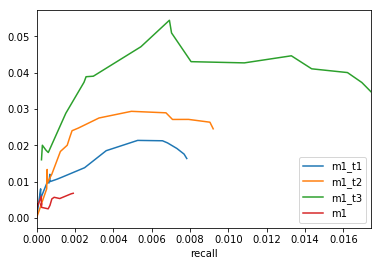

In [276]:
model_comp1 = graphlab.compare(test, [m1_t1,m1_t2,m1_t3,m1],target='rating')
model_comp1_df = model_comp1.to_dataframe()

fig, ax = plt.subplots(1, 1)
for i in range(0,len(model_comp1_df.index)):
    xy_dict= model_comp1_df.loc[i,"results"]['precision_recall']
    xy = pd.DataFrame(xy_dict)    
    #xy.plot(x='recall',y= 'precision',ax=ax)
    label1= model_comp1_df.loc[i,"model"]
    xy.plot(x='recall',y= 'precision',ax=ax,label=label1)
    
plt.show()

Testing the performance of the model on dense data vs sparse data:

In [280]:
import operator
A=ratings.groupby(['userId']).userId.count()
agg_ratings=list(A)
user_Id=range(1,672)
dict_pair=dict(zip(user_Id,agg_ratings))
agg_ratings_sorted=sorted(agg_ratings, reverse=True)
agg_ratings_df = pd.DataFrame({'total_ratings':agg_ratings_sorted})
print (agg_ratings_df)

     total_ratings
0             2391
1             1868
2             1735
3             1700
4             1610
5             1340
6             1291
7             1063
8             1019
9             1011
10             947
11             923
12             922
13             910
14             876
15             830
16             792
17             726
18             713
19             707
20             696
21             682
22             678
23             676
24             655
25             645
26             641
27             626
28             617
29             604
..             ...
641             21
642             21
643             20
644             20
645             20
646             20
647             20
648             20
649             20
650             20
651             20
652             20
653             20
654             20
655             20
656             20
657             20
658             20
659             20
660             20
661         

In [281]:
dict_pair_dense_100={k: v for k, v in dict_pair.iteritems() if v > 100} #filtering users who have rated >100 movies
print len(dict_pair_dense_100), 258/671.0
ratings_sum_dense_100=sum(dict_pair_dense_100.values()) #agg. no of ratings these users casted
print ratings_sum_dense_100
userId_dense=dict_pair_dense_100.keys() # extracting user_ids from dense dictionary
print userId_dense

258 0.384500745156
80487
[514, 4, 598, 518, 519, 8, 522, 523, 525, 15, 528, 17, 19, 21, 22, 23, 536, 516, 26, 30, 544, 33, 34, 547, 36, 605, 38, 41, 43, 558, 559, 48, 520, 562, 563, 564, 56, 57, 570, 607, 572, 61, 574, 575, 577, 67, 68, 582, 609, 72, 73, 75, 77, 78, 548, 592, 81, 83, 84, 85, 86, 599, 88, 602, 91, 92, 93, 94, 95, 608, 97, 99, 102, 529, 105, 615, 620, 110, 111, 624, 626, 531, 118, 119, 120, 553, 125, 533, 128, 641, 130, 133, 134, 647, 584, 652, 654, 655, 656, 659, 148, 149, 150, 527, 152, 665, 623, 157, 159, 165, 585, 168, 169, 534, 175, 176, 177, 178, 627, 182, 185, 187, 189, 603, 195, 199, 200, 201, 205, 212, 213, 214, 217, 219, 220, 550, 232, 234, 235, 236, 239, 240, 242, 243, 245, 247, 250, 251, 253, 254, 255, 257, 537, 262, 263, 265, 268, 270, 275, 282, 283, 285, 287, 292, 646, 294, 295, 297, 299, 303, 304, 648, 306, 309, 311, 312, 313, 316, 324, 328, 339, 342, 344, 345, 346, 350, 353, 355, 358, 362, 363, 367, 371, 373, 378, 380, 381, 382, 384, 386, 387, 388, 390, 3

In [290]:
dense_data = all_data.loc[userId_dense,:]
train_dense, test_dense  = train_test_split(dense_data , test_size=0.2, random_state=42)
train_dense.to_csv("train_dense_data.csv")
test_dense.to_csv("test_dense_data.csv")

In [291]:
train_dense_Sframe= graphlab.SFrame.read_csv("train_dense_data.csv",column_type_hints=hints)
test_dense_Sframe= graphlab.SFrame.read_csv("test_dense_data.csv",column_type_hints=hints)


Finished parsing file C:\Users\hp\Desktop\Jupyter Notebooks\Personalisation-master\Personalisation-master\train_dense_data.csv

Parsing completed. Parsed 206 lines in 0.021013 secs.

Finished parsing file C:\Users\hp\Desktop\Jupyter Notebooks\Personalisation-master\Personalisation-master\test_dense_data.csv

Parsing completed. Parsed 52 lines in 0.020983 secs.

In [292]:
m_dense = graphlab.factorization_recommender.create(train_dense_Sframe, target='rating', user_id='userId',
                                               item_id='movieId',solver= "sgd" , user_data = user_metadata,
                                               item_data = movie_metadata,regularization=1e-06, num_factors=6)

Recsys training: model = factorization_recommender

Preparing data set.

Data has 206 observations with 671 users and 9125 items.

Data prepared in: 0.323745s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 1e-006   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 206 / 206 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 1.21951           | Not Viable                               |

| 1       | 0.304878          | Not Viable                               |

| 2       | 0.0762195         | Not Viable                               |

| 3       | 0.0190549         | Not Viable                               |

| 4       | 0.00476372        | 0.458953                                 |

| 5       | 0.00238186        | 0.568837                                 |

| 6       | 0.00119093        | 0.65903                                  |

| 7       | 0.000595465       | 0.752389                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.00476372        | 0.458953                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 0.971717          | 0.985757              |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 15.51ms      | 0.929609          | 0.964162              | 0.00476372  |

| 2       | 20.015ms     | 0.678876          | 0.823939              | 0.00283252  |

| 3       | 25.017ms     | 0.592121          | 0.769494              | 0.0020898   |

| 4       | 30.023ms     | 0.539935          | 0.734803              | 0.00168423  |

| 5       | 34.024ms     | 0.515992          | 0.718326              | 0.00142468  |

| 6       | 55.538ms     | 0.479352          | 0.692352              | 0.0012426   |

| 11      | 91.064ms     | 0.410824          | 0.640955              | 0.000788682 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.333824

Final training RMSE: 0.577775

In [293]:
m_dense.evaluate_rmse(test_dense_Sframe,target ='rating')

{'rmse_by_item': Columns:
 	movieId	int
 	count	int
 	rmse	float
 
 Rows: 50
 
 Data:
 +---------+-------+----------------+
 | movieId | count |      rmse      |
 +---------+-------+----------------+
 |   431   |   1   | 1.03994908227  |
 |   454   |   1   | 0.835352705907 |
 |   3108  |   1   | 0.997145956157 |
 |   2959  |   1   | 1.58823122281  |
 |   208   |   1   | 0.522173361251 |
 |   356   |   2   |  1.1004675673  |
 |   616   |   1   |  1.3417596253  |
 |   112   |   1   | 1.61649025026  |
 |   1240  |   1   | 0.953923327843 |
 |   1358  |   1   | 3.33852477309  |
 +---------+-------+----------------+
 [50 rows x 3 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.,
 'rmse_by_user': Columns:
 	userId	int
 	count	int
 	rmse	float
 
 Rows: 8
 
 Data:
 +--------+-------+----------------+
 | userId | count |      rmse      |
 +--------+-------+----------------+
 |   2    |   10  | 0.76912636677